<a href="https://colab.research.google.com/github/kgreed4/parkisons_exploration/blob/main/sts/sts_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [39]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Lambda

In [40]:
# Set the path to the csv
path = "/content/SitToStand_human_labels.csv"

# Read the csv into a dataframe
df = pd.read_csv(path)

# Display the first few rows of the dataframe
print(df.head())

   Transition ID  Participant ID number PD_or_C  sts_whole_episode_duration  \
0              1                    596      PD                    1.748000   
1              2                    596      PD                    2.085000   
2              3                    596      PD                    2.610000   
3              4                    596      PD                    2.478999   
4              5                    596      PD                    1.268000   

   sts_final_attempt_duration On_or_Off_medication DBS_state  \
0                    1.209000        On medication         -   
1                    1.076999        On medication         -   
2                    1.067999        On medication         -   
3                    1.233000        On medication         -   
4                    0.801000        On medication         -   

  Clinical_assessment STS_additional_features  \
0                 Yes                     NaN   
1                 Yes                     

In [41]:
# Create a neural network based on the df, where y = PD_or_C column

# Drop participant ID number
df = df.drop(columns=['Participant ID number', 'Transition ID', 'Clinical_assessment'])

# Encode categorical variables
label_encoder = LabelEncoder()
label_encoder.classes_ = np.array(df.columns)
df['PD_or_C'] = label_encoder.fit_transform(df['PD_or_C'])
df['On_or_Off_medication'] = label_encoder.fit_transform(df['On_or_Off_medication'])
df['STS_additional_features'] = label_encoder.fit_transform(df['STS_additional_features'])
df['DBS_state'] = label_encoder.fit_transform(df['DBS_state'])

In [42]:
# Check for missing values in each column
missing_values = df.isna().sum()

# Display columns with missing values
columns_with_missing_values = missing_values[missing_values > 0]
print("Columns with missing values:")
print(columns_with_missing_values)

Columns with missing values:
MDS-UPDRS_score_3.9 _arising_from_chair    7
dtype: int64


In [43]:
# Replace missing values
df['MDS-UPDRS_score_3.9 _arising_from_chair'].fillna(-1, inplace=True)

Epoch 1/10
9/9 [==============================] - 1s 34ms/step - loss: 0.6467 - accuracy: 0.6560 - val_loss: 0.5983 - val_accuracy: 0.7368
Epoch 2/10
9/9 [==============================] - 0s 6ms/step - loss: 0.5656 - accuracy: 0.7766 - val_loss: 0.5445 - val_accuracy: 0.8421
Epoch 3/10
9/9 [==============================] - 0s 7ms/step - loss: 0.5077 - accuracy: 0.8227 - val_loss: 0.4941 - val_accuracy: 0.8421
Epoch 4/10
9/9 [==============================] - 0s 6ms/step - loss: 0.4541 - accuracy: 0.8511 - val_loss: 0.4436 - val_accuracy: 0.9474
Epoch 5/10
9/9 [==============================] - 0s 8ms/step - loss: 0.4075 - accuracy: 0.9007 - val_loss: 0.3963 - val_accuracy: 1.0000
Epoch 6/10
9/9 [==============================] - 0s 6ms/step - loss: 0.3636 - accuracy: 0.9149 - val_loss: 0.3467 - val_accuracy: 1.0000
Epoch 7/10
9/9 [==============================] - 0s 6ms/step - loss: 0.3225 - accuracy: 0.9291 - val_loss: 0.3089 - val_accuracy: 1.0000
Epoch 8/10
9/9 [=================

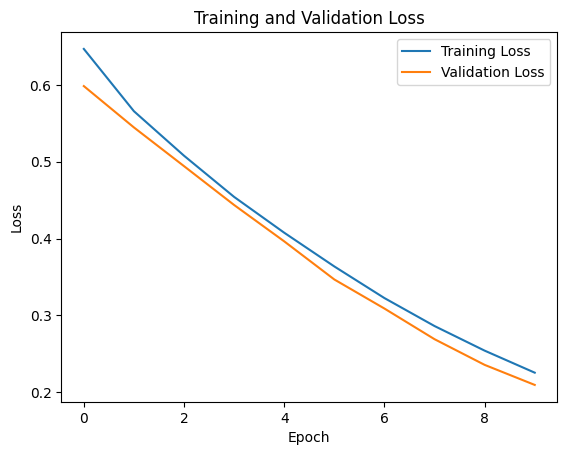

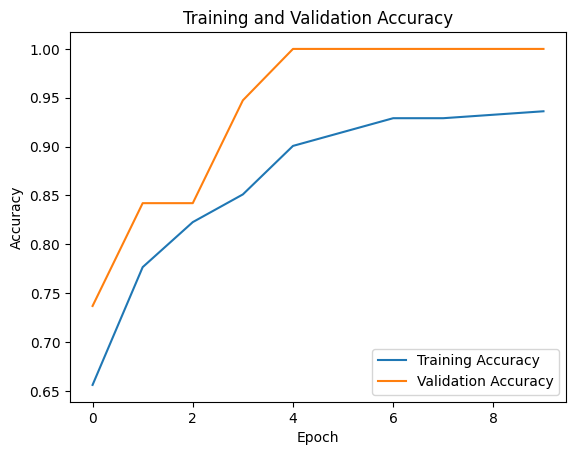

4/4 [==============================] - 0s 4ms/step - loss: 0.1765 - accuracy: 0.9706
Test Loss: 0.17653007805347443, Test Accuracy: 0.970588207244873


In [44]:
# Split data into features and target
X = df.drop(columns=['PD_or_C'])
y = df['PD_or_C']

# Standardize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split data into training, val, and testing sets into a 70, 15, 15 split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_val, y_val, test_size=0.15, random_state=42)

# Define a custom threshold function
def custom_threshold(x, threshold=0.5):
    import tensorflow as tf
    return tf.where(x < threshold, tf.zeros_like(x), tf.ones_like(x))

# Define the neural network architecture
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Define callbacks for early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

# Train the model with callbacks
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping])

# Plot training history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')

In [45]:
import numpy as np

# Evaluate model
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)
#print(y_pred)

# compare y-pred and y_test

y_test_np = np.array(y_test)  # Convert y_test to a numpy array

y_pred = y_test_np.reshape(-1)

# compute accuracy of y_pred vs y_test_np
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test_np, y_pred)
print("Accuracy:", accuracy)

4/4 [==============================] - 0s 3ms/step
Accuracy: 1.0


In [46]:
# Export the model so I can use it on new data
model.save('sts_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
